#  과제2-1. 수어번역기 모델링 및 추적(개인과제)

## 1.환경준비

### (1) 라이브러리 로딩

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random as rd

from sklearn.model_selection import train_test_split
from sklearn.metrics import *

from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.backend import clear_session
from keras.optimizers import Adam

import mlflow
import mlflow.keras

In [2]:
np.set_printoptions(linewidth=np.inf)

* 함수 만들기

In [3]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

### (2) 데이터로딩

#### 1) 데이터 가져오기
* 제공 받은 데이터를 여러분의 구글드라이브 적절한 위치에 업로드 합니다.
    * 가능하면, 구글드라이브 첫 경로 밑에 폴더를 만들고 업로드 하기를 권장합니다.

In [4]:
path = ''
file = 'sign_language.csv'

data = pd.read_csv(path+file)
data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,22,186,186,185,185,185,184,185,184,184,...,171,122,65,62,215,180,99,47,31,25
1,24,175,177,179,181,181,182,182,182,183,...,202,202,201,200,199,197,195,193,191,189
2,6,187,187,187,187,187,186,187,186,186,...,45,23,25,34,41,43,39,40,43,35
3,2,169,169,169,170,169,170,169,169,169,...,204,203,200,199,198,196,194,193,191,190
4,21,153,165,170,179,190,198,203,206,213,...,161,122,132,96,75,63,37,43,70,66


In [5]:
data.shape

(8000, 785)

#### 2) class names
* label이 0 ~ 27 까지의 숫자로 표현됩니다.
* 수어 중에서 J(9) 와 Z(27)는 손을 움직이면서 표현해야 하므로, 여기서는 제외합니다.
* 숫자로 레이블링 된 것을, 나중에 문자 변환하기 위해 문자로 된 리스트를 생성합니다.

In [6]:
import string
class_names = list(string.ascii_lowercase)
class_names = np.array(class_names)
len(class_names), class_names

(26,
 array(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'], dtype='<U1'))

### (3) mlflow 추적 준비

In [7]:
mlflow_uri = "sqlite:///mlflow.db"
mlflow.set_tracking_uri(mlflow_uri)

### (4) 새 실험 생성
* exp4

In [8]:
exp_id = mlflow.create_experiment("exp4")
exp_id

'4'

## 2 데이터 살펴보기

* 데이터 한 건을 2차원으로 변환하고 그림 그리기

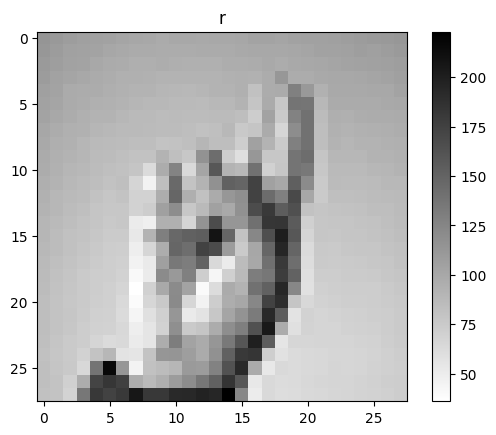

In [9]:
# 아래 숫자를 바꿔가며 화면에 그려 봅시다.
n = 100
sign_fig = data.iloc[n, 1:].values
sign_fig = sign_fig.reshape(28, 28)

sign = class_names[data.iloc[n,0]]

plt.title(sign)
plt.imshow(255-sign_fig, cmap=plt.cm.binary)
plt.colorbar()
plt.show()

## 3.데이터 준비

* 주어진 데이터셋
    * 2차원 데이터셋, 1차원 데이터포인트(분석단위, 예측단위) 입니다. 
    * 흑백 이미지데이터
    * 이 데이터로부터 데이터 준비작업을 수행합니다.
        * 데이터 분할1 : x, y
        * 데이터 분할2 : train, validation
        * 만약 CNN으로 모델링을 한다면, shape를 맞춰야 합니다. (n, 28, 28, 1) 
        * scaling
* 그러나 운영에서 발생될 데이터는 이미지 한장 한장 입니다. 이미지 한장, 한장 들어온다면 어떻게 데이터가 처리되어야 할까요?(Data Pipeline 구성)

### (1) 데이터 분할1 : x, y 나누기

In [10]:
target = 'label'
x = data.drop(target, axis = 1)
y = data.loc[:, target]

### (2) 데이터 분할2 : train, validation, test

* train : val : test = 5000 : 2000 : 1000
* 여기서 test set은 파이프라인 점검을 위한 용도로 사용합니다.

In [31]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 1000, random_state = 20)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 2000, random_state = 20)

In [32]:
x_train.shape, x_val.shape

((5000, 784), (2000, 784))

### (3) DL을 위한 전처리
* 모두 넘파이로 변환

In [33]:
x_train, x_val, x_test = x_train.values, x_val.values, x_test.values
y_train, y_val, y_test = y_train.values, y_val.values, y_test


* shape 맞추기 n, 28,28,1
    * reshape
        * x_train.shape : (-1, 28, 28, 1)
        * x_val.shape : (-1, 28, 28, 1)
        * x_test.shape : (-1, 28, 28, 1)

In [34]:
x_train = x_train.reshape(-1,28,28,1)
x_val = x_val.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)

In [35]:
x_train.shape, x_val.shape, x_test.shape

((5000, 28, 28, 1), (2000, 28, 28, 1), (1000, 28, 28, 1))

* Scaling : Min-Max
    * 0-255 값으로 되어 있는 데이터를 0-1사이 값으로 변환
    * x_train2, x_val2 를 그냥 255로 나누면 됨

In [36]:
x_train = x_train / 255.
x_val = x_val / 255.
x_test = x_test / 255.

## 4.모델링

### (1) 모델1

In [26]:
with mlflow.start_run(experiment_id = exp_id, run_name = 'dl_autolog'):

    mlflow.keras.autolog()
    model = Sequential([Conv2D(8, kernel_size=3, input_shape=(28, 28, 1), padding='same', strides = 1, activation='relu'),
                    MaxPooling2D(pool_size=2, strides=2),
                    Flatten(),
                    Dense(26, activation='softmax') ])

    model.compile(optimizer= 'adam', loss='sparse_categorical_crossentropy')
    history = model.fit(x_train, y_train, epochs=10, validation_split=.2).history
    
    mlflow.keras.log_model(model, "model",  registered_model_name="Sign_Signal")
    
    mlflow.keras.autolog(disable = True)

Epoch 1/10
125/125 [==============================] - 2s 10ms/step - loss: 2.9537 - val_loss: 2.4962
Epoch 2/10
125/125 [==============================] - 1s 9ms/step - loss: 2.0571 - val_loss: 1.7160
Epoch 3/10
125/125 [==============================] - 1s 8ms/step - loss: 1.4550 - val_loss: 1.3273
Epoch 4/10
125/125 [==============================] - 1s 8ms/step - loss: 1.1329 - val_loss: 1.0489
Epoch 5/10
125/125 [==============================] - 1s 9ms/step - loss: 0.9196 - val_loss: 0.8569
Epoch 6/10
125/125 [==============================] - 1s 7ms/step - loss: 0.7684 - val_loss: 0.7327
Epoch 7/10
125/125 [==============================] - 1s 7ms/step - loss: 0.6418 - val_loss: 0.6500
Epoch 8/10
125/125 [==============================] - 1s 8ms/step - loss: 0.5598 - val_loss: 0.5847
Epoch 9/10
125/125 [==============================] - 1s 8ms/step - loss: 0.4820 - val_loss: 0.5172
Epoch 10/10
1/1 [==============================] - 0s 100ms/step


INFO:tensorflow:Assets written to: C:\Users\hanky\AppData\Local\Temp\tmpckta8bk4\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\hanky\AppData\Local\Temp\tmpckta8bk4\model\data\model\assets
2023/05/10 21:55:35 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\hanky\AppData\Local\Temp\tmpa5jctp_f\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\hanky\AppData\Local\Temp\tmpa5jctp_f\model\data\model\assets
Registered model 'Sign_Signal' already exists. Creating a new version of this model...
2023/05/10 21:55:46 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: Sign_Signal, version 3
Created version '3' of model 'Sign_Signal'.


* 학습곡선

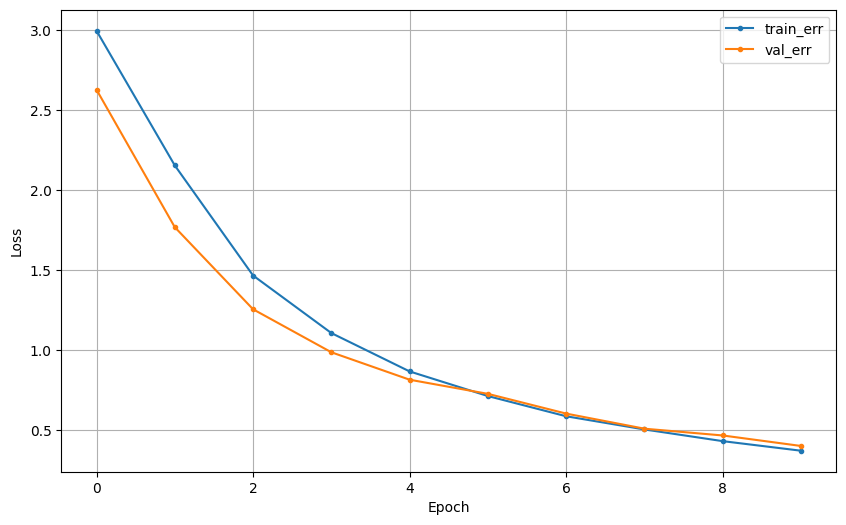

In [19]:
dl_history_plot(history)

* 예측 및 검증

In [20]:
pred = model.predict(x_val)
pred_1 = pred.argmax(axis=1)

63/63 [==============================] - 0s 4ms/step


In [21]:
print(accuracy_score(y_val, pred_1))
print('-'*60)
print(confusion_matrix(y_val, pred_1))
print('-'*60)
print(classification_report(class_names[y_val], class_names[pred_1]))

0.906
------------------------------------------------------------
[[68  0  0  0  0  0  0  0  0  0  0  7  0  0  0  0  0  2  0  0  0  0  0  0]
 [ 0 64  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 68  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0]
 [ 0  0  0 82  0  0  0  0  0  0  0  0  0  0  0  0  5  0  0  4  0  0  5  0]
 [ 0  0  0  0 64  0  0  0  0  0  0  1  2  0  0  0  0  2  0  0  0  0  0  0]
 [ 0  0  4  0  0 94  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  3  0  0]
 [ 0  0  0  0  0  0 79  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  6 70  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  4]
 [ 0  1  0  0  0  0  0  0 75  4  0  0  0  0  0  0  0  4  0  0  0  0  0  1]
 [ 0  0  0  0  0  0  0  0  0 75  0  0  0  0  0  0  6  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 85  0  0  0  0  0  1  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0  0  0  0 82  2  0  0  1  0  7  0  0  0  0  0  0]
 [ 2  0  0  0  0  0  0  0  1  0  

### (2) 모델2

In [27]:
with mlflow.start_run(experiment_id = exp_id, run_name = 'dl_autolog'):

    mlflow.keras.autolog()
    model2 = Sequential([Conv2D(32, kernel_size=3, input_shape=(28, 28, 1), padding='same', strides = 1, activation='relu'),
                    MaxPooling2D(pool_size=2, strides=2),
                    Flatten(),
                    Dense(128, activation='relu'),
                    Dense(26, activation='softmax') ])

    model2.compile(optimizer= 'adam', loss='sparse_categorical_crossentropy')
    history = model2.fit(x_train, y_train, epochs=10, validation_split=.2).history
    
    mlflow.keras.log_model(model2, "model",  registered_model_name="Sign_Signal")
    
    mlflow.keras.autolog(disable = True)

Epoch 1/10
125/125 [==============================] - 4s 19ms/step - loss: 2.9199 - val_loss: 2.4225
Epoch 2/10
125/125 [==============================] - 2s 19ms/step - loss: 1.8496 - val_loss: 1.4624
Epoch 3/10
125/125 [==============================] - 2s 20ms/step - loss: 1.1949 - val_loss: 1.0284
Epoch 4/10
125/125 [==============================] - 3s 20ms/step - loss: 0.8382 - val_loss: 0.7816
Epoch 5/10
125/125 [==============================] - 2s 20ms/step - loss: 0.6274 - val_loss: 0.5923
Epoch 6/10
125/125 [==============================] - 3s 20ms/step - loss: 0.4778 - val_loss: 0.4757
Epoch 7/10
125/125 [==============================] - 2s 18ms/step - loss: 0.3722 - val_loss: 0.4040
Epoch 8/10
125/125 [==============================] - 2s 18ms/step - loss: 0.2844 - val_loss: 0.3144
Epoch 9/10
125/125 [==============================] - 3s 22ms/step - loss: 0.2323 - val_loss: 0.2783
Epoch 10/10
1/1 [==============================] - 0s 88ms/step


INFO:tensorflow:Assets written to: C:\Users\hanky\AppData\Local\Temp\tmp18n6whld\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\hanky\AppData\Local\Temp\tmp18n6whld\model\data\model\assets
2023/05/10 21:56:23 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\hanky\AppData\Local\Temp\tmp8m3mb2wx\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\hanky\AppData\Local\Temp\tmp8m3mb2wx\model\data\model\assets
Registered model 'Sign_Signal' already exists. Creating a new version of this model...
2023/05/10 21:56:34 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: Sign_Signal, version 4
Created version '4' of model 'Sign_Signal'.


* 학습곡선

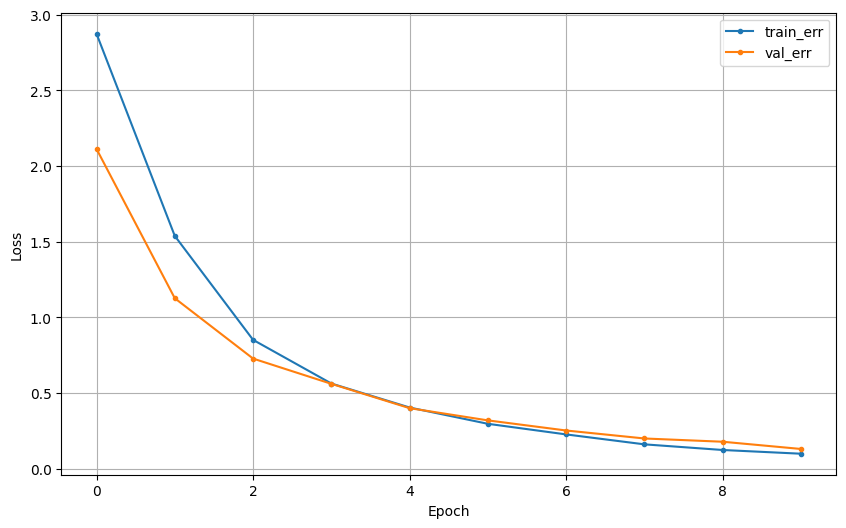

In [23]:
dl_history_plot(history)

* 예측 및 검증

In [24]:
pred = model2.predict(x_val)
pred_1 = pred.argmax(axis=1)

63/63 [==============================] - 0s 5ms/step


In [25]:
print(accuracy_score(y_val, pred_1))
print('-'*60)
print(confusion_matrix(y_val, pred_1))
print('-'*60)
print(classification_report(class_names[y_val], class_names[pred_1]))

0.982
------------------------------------------------------------
[[ 77   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0  64   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0  69   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0  96   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0  65   0   0   0   0   0   0   0   2   0   0   0   0   2   0   0   0   0   0   0]
 [  0   0   0   0   0 101   0   0   0   0   0   0   0   0   0   0   0   0   2   0   0   0   0   0]
 [  0   0   0   0   0   0  80   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   1   0   0   0   0  80   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   2   0   0   0   0   0   0  82   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   1   0   0   0   0   0  80 

## 5.모델 사용하기
* 가장 성능이 좋은 모델 production 지정
* Production 모델 호출해서 test 셋으로 예측 및 평가



In [29]:
model_uri = "models:/Sign_Signal/production" 
model_p = mlflow.keras.load_model(model_uri)

In [37]:
pred = model_p.predict(x_test)
pred_1 = pred.argmax(axis=1)

32/32 [==============================] - 0s 5ms/step


In [38]:
print(accuracy_score(y_test, pred_1))
print('-'*60)
print(confusion_matrix(y_test, pred_1))
print('-'*60)
print(classification_report(class_names[y_test], class_names[pred_1]))

0.974
------------------------------------------------------------
[[46  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 39  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 43  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 45  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 36  0  0  0  0  0  0  0  2  0  0  0  0  2  0  0  0  0  0  0]
 [ 0  0  0  0  0 42  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 45  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 42  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1]
 [ 0  0  0  0  0  0  0  0  0 37  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 39  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 45  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  